# Siamese network


In [1]:
import random
import cv2
import numpy as np
import PIL
import os
import sys
import glob
from PIL import Image
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam
import tensorflow as tf


from sklearn.model_selection import train_test_split

In [58]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("jessicali9530/caltech256")

# print("Path to dataset files:", path)

In [58]:
def imshow(a, size=1.0):
    # if image was normalized
    if a.max() <= 1.0:
        a = (a * 255).astype("uint8")

    # Clip and convert the image to uint8
    elif a.dtype != np.uint8:
        a = np.clip(a, 0, 255).astype("uint8")
    
    # Resize the image if a size factor is provided
    if size != 1.0:
        new_dim = (int(a.shape[1] * size), int(a.shape[0] * size))
        a = cv2.resize(a, new_dim, interpolation=cv2.INTER_AREA)
    
    # Convert color format if needed
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    
    # Display the image
    display(PIL.Image.fromarray(a))

## Train val test split

In [127]:
base_dir = "/kaggle/input/search-engine-data/Data"

def get_split_paths_labels(base_dir, num_folders=None):
    """
    data sturcture: base_dir/class_name/image.jpg,
    splits the data into train, validation and test sets, such that 80% of the data from each folder is used for training, 10% for validation and 10% for testing
    if one wants to use less than the whole data -> change the num_folders parameter (each folder contains about 100+ images)
    returns: train_paths, train_labels, val_paths, val_labels, test_paths, test_labels
    """
    folder_names = os.listdir(base_dir)
    if num_folders:
        folder_names = folder_names[:num_folders]
    train_paths = []
    train_labels = []
    val_paths = []
    val_labels = []
    test_paths = []
    test_labels = []

    for folder in folder_names:
        label = folder[:3]
        image_files = glob.glob(os.path.join(base_dir, folder, "*.jpg"))
        random.shuffle(image_files)

        num_images = len(image_files)
        train_split = int(0.8 * num_images) # 80% goes to train
        val_split = int(0.9 * num_images) # 10% goes to validation and 10 % goes to test

        train_files = image_files[:train_split]
        val_files = image_files[train_split:val_split]
        test_files = image_files[val_split:]

        train_paths.extend(train_files)
        train_labels.extend([label] * len(train_files))

        val_paths.extend(val_files)
        val_labels.extend([label] * len(val_files))

        test_paths.extend(test_files)
        test_labels.extend([label] * len(test_files))

        
    return train_paths, train_labels, val_paths, val_labels, test_paths, test_labels

## Data generator 


1. Generate pairs - generate file pairs, assign label to pair, 1 - if from the same group, 0 - if from different

In [139]:
def generate_pairs(file_paths, labels):

    num_pairs = len(file_paths) // 2
    file_paths = np.array(file_paths)
    labels = np.array(labels)

    label_to_files = {} # dictionary with labels as keys and list of files from a group as values
    for i, label in enumerate(labels):
        label_to_files.setdefault(label, []).append(file_paths[i])
        
    # generate more or less the same number of positive and negative pairs
    num_positive_pairs = num_pairs // 2 
    num_negative_pairs = num_pairs - num_positive_pairs

    pairs = []
    pair_labels =[]
    
    while len(pairs) < num_positive_pairs:
        label = random.choice(list(label_to_files.keys())) 
        if len(label_to_files[label]) < 2:  # skip if there are not enough images left
            continue
        image1, image2 = random.sample(label_to_files[label], 2) # two images from the same class
        pairs.append((image1, image2))
        pair_labels.append(1)
        label_to_files[label].remove(image1)
        label_to_files[label].remove(image2)
        
        if len(label_to_files[label]) == 0:
            del label_to_files[label]
        

    while len(pairs) < num_pairs:
        if len(label_to_files) < 2:
            break
        label1, label2 = random.sample(list(label_to_files.keys()), 2) # two different classes
        if len(label_to_files[label1]) == 0 or len(label_to_files[label2]) == 0:  # Skip if no images are left
            continue
        image1 = random.choice(label_to_files[label1])
        image2 = random.choice(label_to_files[label2])
        pairs.append((image1, image2))
        pair_labels.append(0)
        label_to_files[label1].remove(image1) 
        label_to_files[label2].remove(image2) 
        
        if len(label_to_files[label1]) == 0:
            del label_to_files[label1]
        if len(label_to_files[label2]) == 0:
            del label_to_files[label2]
        
    # for label, files in label_to_files.items():
    #     print(f"Label {label}: {len(files)} images")

    # shuffle the pairs
    combined = list(zip(pairs, pair_labels))
    random.shuffle(combined)
    pairs, pair_labels = zip(*combined)

    return np.array(pairs), np.array(pair_labels)


2. preprocessing funnctions - same as those included in data generator, however, useful for evaluation

In [129]:
def resize_crop(image, image_size=(256, 256)):
    target_height, target_width = image_size
    original_height, original_width = image.shape[:2]

    original_aspect = original_width / original_height
    target_aspect = target_width / target_height

    if original_aspect > target_aspect:
        new_width = original_height
        crop_x = (original_width - new_width) // 2
        cropped_image = image[:, crop_x:crop_x + new_width]
    elif original_aspect < target_aspect:
        new_height = original_width
        crop_y = (original_height - new_height) // 2
        cropped_image = image[crop_y:crop_y + new_height, :]
    else:
        cropped_image = image

    resized_image = cv2.resize(cropped_image, (target_width, target_height))
    return resized_image

def preprocess(image):
    image = image / 255.0
    image = resize_crop(image)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    return image

def read_and_preprocess(image_file):
    image = cv2.imread(image_file)
    image = preprocess(image) 
    return image 
    

3. data gen

In [130]:
class SiameseDataGenerator(Sequence):
    def __init__(self, pairs, pair_labels, batch_size=32, image_size=(256, 256), shuffle=True):
        self.pairs = pairs
        self.pair_labels = pair_labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.pairs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    """
    read_images 
    reads image, 
    preproces image (normalize, resize(by cropping), blur)
    """
    def read_image(self, image_file):
        image = cv2.imread(image_file)
        image = self.preprocess(image) 
        return image        

    """
    resize_crop
    resizes to desired size by cropping the image,
    in order to not strech the picture
    """
    def resize_crop(self, image):
        target_height, target_width = self.image_size
        original_height, original_width = image.shape[:2]

        original_aspect = original_width / original_height
        target_aspect = target_width / target_height

        if original_aspect > target_aspect:
            new_width = original_height
            crop_x = (original_width - new_width) // 2
            cropped_image = image[:, crop_x:crop_x + new_width]
        elif original_aspect < target_aspect:
            new_height = original_width
            crop_y = (original_height - new_height) // 2
            cropped_image = image[crop_y:crop_y + new_height, :]
        else:
            cropped_image = image

        resized_image = cv2.resize(cropped_image, (target_width, target_height))
        return resized_image

    def preprocess(self, image):
        image = image / 255.0
        image = self.resize_crop(image)
        image = cv2.GaussianBlur(image, (5, 5), 0)
        return image


    def __len__(self):
        return int(np.floor(len(self.pairs) / self.batch_size))

    """
    selects batch indices,
    loads and preprocesses the batch images,
    returns a pair of immages and teir pair label
    """
    def __getitem__(self, index):
        # select a batch of indexes
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        batch_images1 = []
        batch_images2 = []
        batch_labels = []

        # load and preprocess the batch
        for i in batch_indexes:
            pair = self.pairs[i]
            label = self.pair_labels[i]

            image1 = self.read_image(pair[0])
            image2 = self.read_image(pair[1])

            batch_images1.append(image1)
            batch_images2.append(image2)
            batch_labels.append(label)

        # convert to numpy arrays
        batch_images1 = np.array(batch_images1, dtype=np.float32)
        batch_images2 = np.array(batch_images2, dtype=np.float32)
        batch_labels = np.array(batch_labels, dtype=np.float32)

        return (batch_images1, batch_images2), batch_labels        

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


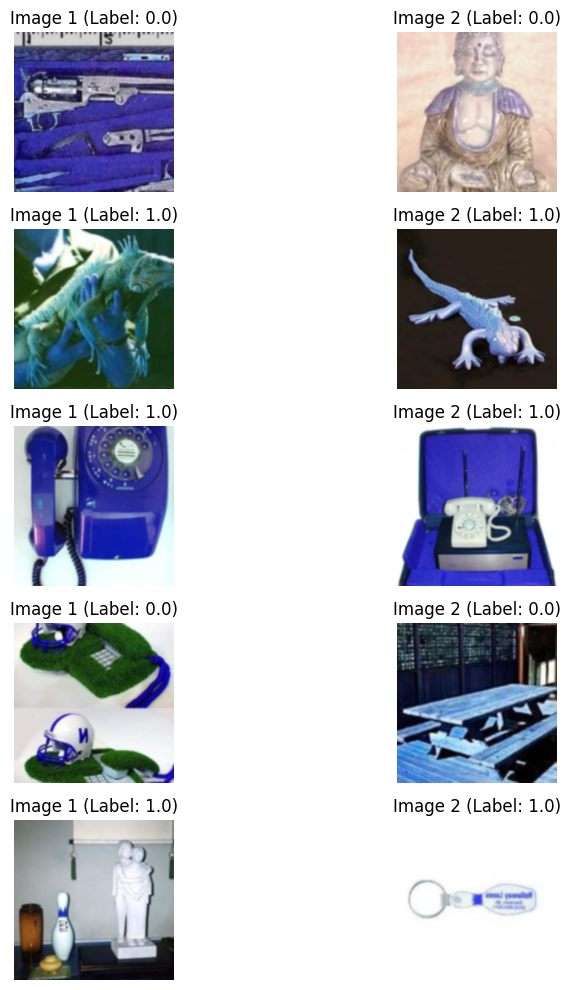

1545


In [140]:
def display_batch(generator, num_pairs=5):
    x, y = generator[11]
    pair_images_1 = x[0]  # first image in each pair
    pair_images_2 = x[1]  # second image in each pair
    labels = y

    plt.figure(figsize=(10, 10))

    for i in range(num_pairs):
        image1 = pair_images_1[i]
        image2 = pair_images_2[i]
        label = labels[i]

        plt.subplot(num_pairs, 2, i * 2 + 1)
        plt.imshow(image1)
        plt.axis('off')
        plt.title(f"Image 1 (Label: {label})")

        plt.subplot(num_pairs, 2, i * 2 + 2)
        plt.imshow(image2)
        plt.axis('off')
        plt.title(f"Image 2 (Label: {label})")

    plt.tight_layout()
    plt.show()

# example usage
base_dir = "/kaggle/input/search-engine-data/Data"
train_paths, train_labels, val_paths, val_labels, test_paths, test_labels = get_split_paths_labels(base_dir)
val_pairs, val_labels = generate_pairs(val_paths, val_labels)
batch_size = 32
example_data_generator = SiameseDataGenerator(val_pairs, val_labels)
display_batch(example_data_generator, num_pairs=5)
print(len(val_pairs))

## Model

In [2]:
# base model that will be used to extract features from the images, creates a feature vector of size 128
def build_base_network(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (7, 7), activation="relu", padding="same")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (5, 5), activation="relu", padding="same")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    outputs = Dense(128, activation="relu")(x) # 128-dimensional feature vector
    return Model(inputs, outputs)

# full siamese network that takes two images as input and outputs a binary classification
def build_siamese_network(input_shape):
    base_network = build_base_network(input_shape)
    
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    
    encoded_a = base_network(input_a)
    encoded_b = base_network(input_b)
    
    # Compute the L2 distance between the encoded vectors
    l2_distance = Lambda(lambda tensors: K.sqrt(K.sum(K.square(tensors[0] - tensors[1]), axis=-1)))([encoded_a, encoded_b])
    
    return Model(inputs=[input_a, input_b], outputs=l2_distance)


## Training

In [142]:
base_dir = "/kaggle/input/search-engine-data/Data"
train_paths, train_labels, val_paths, val_labels, test_paths, test_labels = get_split_paths_labels(base_dir)
train_pairs, train_pair_labels = generate_pairs(train_paths, train_labels)
val_pairs, val_pair_labels = generate_pairs(val_paths, val_labels)


In [3]:
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [4]:
"""
custom accuracy
as the network outputs distances and labels are 0 and 1, assume a threshold and convert predictions to binary based on threshold
"""
def siamese_accuracy(y_true, y_pred, threshold=0.3):
    # y_true: labels (0 or 1)
    # y_pred:  L2 distances
    
    # convert distances to binary predictions (0 for dissimilar, 1 for similar)
    predictions = K.cast(K.less_equal(y_pred, threshold), K.floatx())
    
    # compare predictions with ground truth
    correct_predictions = K.equal(predictions, y_true)
    accuracy = K.mean(K.cast(correct_predictions, K.floatx()))
    return accuracy


In [6]:

optimizer = Adam(learning_rate=0.0005)
input_shape = (256, 256, 3) 
siamese_model = build_siamese_network(input_shape)
siamese_model.compile(optimizer=optimizer, loss=contrastive_loss, metrics=["accuracy", siamese_accuracy] )
siamese_model.summary()

# train_generator = SiameseDataGenerator(train_pairs, train_pair_labels, batch_size=32, image_size=(256, 256), shuffle=True)
# val_generator = SiameseDataGenerator(val_pairs, val_pair_labels, batch_size=32, image_size=(256, 256), shuffle=False)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_2        │ (None, 128)       │ 34,064,128 │ input_layer_4[0]… │
│ (Functional)        │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None)            │          0 │ functional_2[0][… │
│                     │                   │            │ functional_2[1][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,064,128 (129.94 MB)

 Trainable params: 34,064,128 (129.94 MB)

 Non-trainable params: 0 (0.00 B)

In [146]:
early_stopping = EarlyStopping(
    monitor="val_loss", 
    patience=10,         
    restore_best_weights=True  
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   # Metric to monitor
    factor=0.2,           # The factor by which the learning rate will be reduced
    patience=3,           # Number of epochs to wait before reducing LR
    min_lr=1e-6           # Minimum learning rate
)

history = siamese_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 198s 496ms/step - accuracy: 0.0189 - loss: 2.0259 - siamese_accuracy: 0.5564 - val_accuracy: 0.0000e+00 - val_loss: 0.2525 - val_siamese_accuracy: 0.5755 - learning_rate: 5.0000e-04
Epoch 2/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 152s 387ms/step - accuracy: 0.0011 - loss: 0.2469 - siamese_accuracy: 0.5737 - val_accuracy: 0.0000e+00 - val_loss: 0.2494 - val_siamese_accuracy: 0.5345 - learning_rate: 5.0000e-04
Epoch 3/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 156s 397ms/step - accuracy: 0.0044 - loss: 0.2314 - siamese_accuracy: 0.5843 - val_accuracy: 0.0000e+00 - val_loss: 0.2476 - val_siamese_accuracy: 0.5625 - learning_rate: 5.0000e-04
Epoch 4/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 154s 392ms/step - accuracy: 0.0169 - loss: 0.2099 - siamese_accuracy: 0.6100 - val_accuracy: 0.0208 - val_loss: 0.2487 - val_siamese_accuracy: 0.5521 - learning_rate: 5.0000e-04
Epoch 5/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 157s 400ms/step - accuracy: 0.0000e+00 - loss: 0.1865 - siamese_accuracy: 0.

In [147]:
base_network = siamese_model.layers[2]  # extract the base network

## Embeddings, evaluating 

In [148]:
# in order to not use up all the memory data generator is needed 

class CustomImageProcessor:
    def __init__(self, image_size):
        self.image_size = image_size

    """
    Reads and preprocesses an image (normalize, resize, crop, blur)
    """
    def read_image(self, image_file):
        image = cv2.imread(image_file)
        image = self.preprocess(image)
        return image

    """
    Resize and crop image to target size without stretching
    """
    def resize_crop(self, image):
        target_height, target_width = self.image_size
        original_height, original_width = image.shape[:2]

        original_aspect = original_width / original_height
        target_aspect = target_width / target_height

        if original_aspect > target_aspect:
            new_width = int(original_height * target_aspect)
            crop_x = (original_width - new_width) // 2
            cropped_image = image[:, crop_x:crop_x + new_width]
        elif original_aspect < target_aspect:
            new_height = int(original_width / target_aspect)
            crop_y = (original_height - new_height) // 2
            cropped_image = image[crop_y:crop_y + new_height, :]
        else:
            cropped_image = image

        resized_image = cv2.resize(cropped_image, (target_width, target_height))
        return resized_image

    """
    Preprocesses image: normalize, resize, and apply Gaussian blur
    """
    def preprocess(self, image):
        image = image / 255.0
        image = self.resize_crop(image)
        image = cv2.GaussianBlur(image, (5, 5), 0)
        return image

    """
    Generator to process images in batches
    """
    def image_generator(self, image_paths, batch_size):
        while True:
            for i in range(0, len(image_paths), batch_size):
                batch_paths = image_paths[i:i + batch_size]
                batch_images = []
                for image_path in batch_paths:
                    processed_image = self.read_image(image_path)
                    batch_images.append(processed_image)
                yield np.array(batch_images)



In [149]:
def extract_embeddings_with_paths(base_model, image_paths, batch_size, image_size, base_dir="/kaggle/input/search-engine-data/Data", output_file="embeddings_with_paths.npy"):
    processor = CustomImageProcessor(image_size=image_size)
    generator = processor.image_generator(image_paths, batch_size)

    embeddings_with_paths = [] 
    for i, batch in enumerate(generator):

        batch_paths = image_paths[i * batch_size:(i + 1) * batch_size]
        batch_embeddings = base_model.predict(batch)

        for embedding, full_path in zip(batch_embeddings, batch_paths):
            relative_path = os.path.relpath(full_path, base_dir) # extracting path by removing base dir
            embeddings_with_paths.append({"path": relative_path, "embedding": embedding})
        
        if len(embeddings_with_paths) >= len(image_paths):
            break

    np.save(output_file, embeddings_with_paths)
    print(f"Embeddings saved to {output_file}")
    
    return embeddings_with_paths


In [150]:
embeddings = extract_embeddings_with_paths(base_network, train_paths, batch_size=32, image_size=(256, 256))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

In [151]:
def calculate_euclidean_distance(feature1, feature2):
    return np.linalg.norm(feature1 - feature2)

In [152]:
def top_k(query, embeddings_with_paths, base_model, k=5):


    query_preprocessed = read_and_preprocess(query)
    query_feature = base_model.predict(np.expand_dims(query_preprocessed, axis=0))
    
    distances = [
        calculate_euclidean_distance(query_feature, entry["embedding"]) for entry in embeddings_with_paths
    ]
    
    top_k_indices = np.argsort(distances)[:k]
    
    top_k_results = [
        {"path": embeddings_with_paths[i]["path"], "distance": distances[i]} for i in top_k_indices
    ]
    
    return top_k_results


def display_top_k(query, top_k_results, base_dir, k=5):

    fig, axes = plt.subplots(1, k + 1, figsize=(15, 5))  # 1 for query, k for top results

    query = read_and_preprocess(query)
    axes[0].imshow(query)
    axes[0].set_title("Query")
    axes[0].axis('off')
    
    for i, ax in enumerate(axes[1:]):
        img_path = os.path.join(base_dir, top_k_results[i]["path"])
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.set_title(f"Dist: {top_k_results[i]['distance']:.2f}")
        ax.axis('off')
    
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


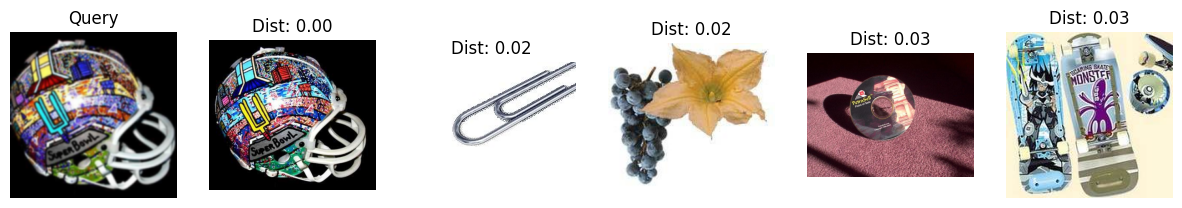

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


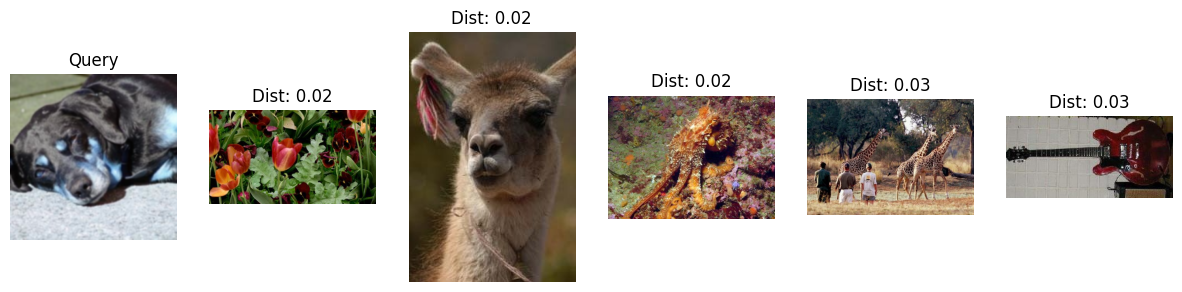

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


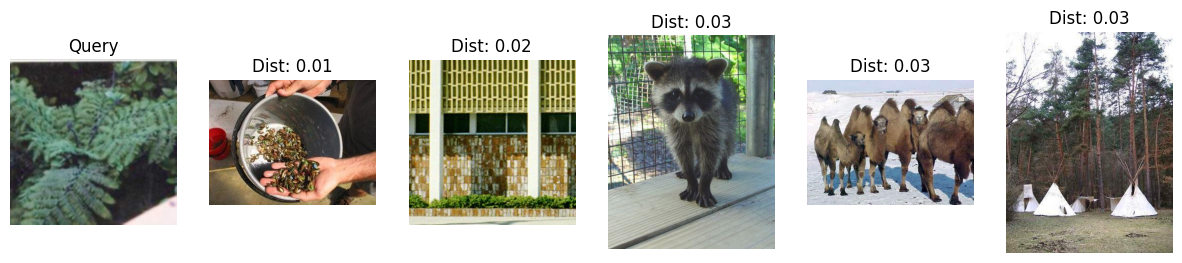

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


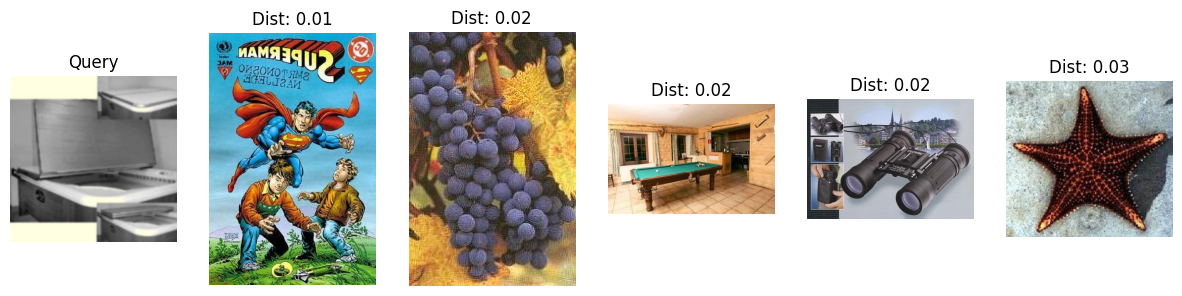

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


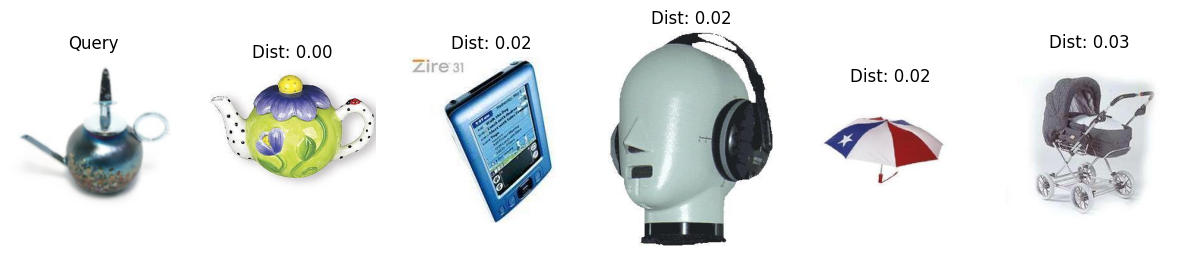

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


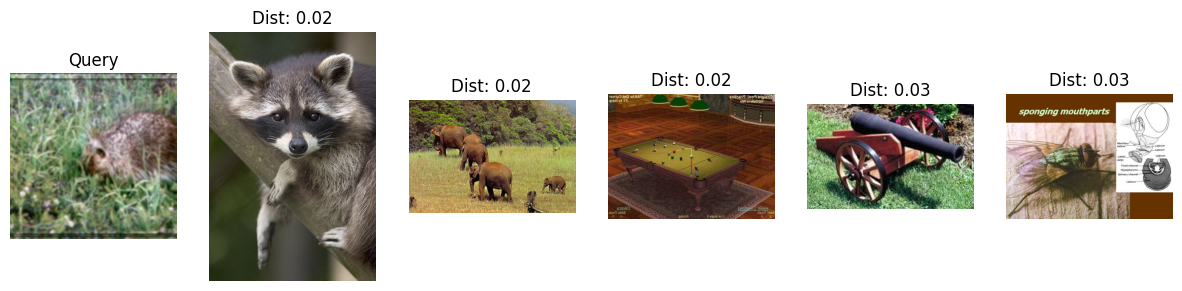

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


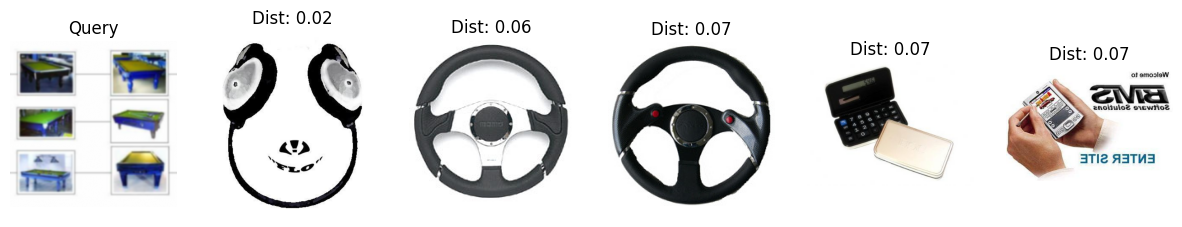

In [155]:
base_dir = "/kaggle/input/search-engine-data/Data"
query = train_paths[1]
top_5 = top_k(query, embeddings, base_network)
display_top_k(query, top_5, base_dir)

idx = [222, 12, 456, 777, 2000, 397]

for i in idx:
    base_dir = "/kaggle/input/search-engine-data/Data"
    query = test_paths[i]
    top_5 = top_k(query, embeddings, base_network)
    display_top_k(query, top_5, base_dir)